Integrantes:

* Juan Carlos Sánchez
* Nicolás Eduardo Pardo
* David Esteban Casallas


Nota importante, este colab solo se usa para exhibir las funciones y el paso a paso pero el contenido del proyecto con explicaciones, conclusiones y teoría están en el PDF del proyecto.

## Imports

In [ ]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io
from hmmlearn.hmm import GaussianHMM
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, skewtest, kurtosistest, kstest, norm, multivariate_normal
import scipy.stats as stats
import seaborn as sns
from sklearn.mixture import GaussianMixture
from hmmlearn import hmm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Proyecto



## Datos

En esta sección se realiza algo de analisis de los datos para justificar el procedimiento, creando así un modelo de Markov oculto que busca predecir el comportamiento de la bolsa de valores.


In [ ]:
data = yf.download("^GSPC", start="2000-01-01", end="2023-10-01")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


No vamos a utilizar todos los datos para la creación, necesitamos algunos para probar el modelo posteriormente y ver su rendimiento.

In [ ]:
t_size = int(0.8*data.shape[0]) #Separamos en 80 - 20
train_d = data.iloc[0:t_size] # 80 para el entrenamiento
test_d = data.iloc[t_size+1:] # 20 para la prueba

Para entrenar el modelo no vamos a utilizar los 6 atributos sin más, vamos a obtener unas caracteristicas que representan el comportamiento que nos interesa predecir, en este caso el cambio fraccional.

In [ ]:
def features(df):

    fraco = (df['Close']-df['Open'])/df['Open'] # Cambio fraccional apertura-cierre
    frach = (df['High']-df['Open'])/df['Open'] # Cambio fraccional apertura-alto
    fracl = (df['Open']-df['Low'])/df['Open'] # Cambio fraccional apertura-bajo

    new_df = pd.DataFrame({'OpenClose': fraco, 'HighOpen': frach, 'LowOpen': fracl})
    new_df.set_index(df.index)

    return new_df

def stack_features(df):
    return np.column_stack((df['OpenClose'], df['HighOpen'], df['LowOpen']))

In [ ]:
features_df = features(data)
features_array = stack_features(features_df)
features_df.head()

,OpenClose,HighOpen,LowOpen
Date,,,
2000-01-03,-0.009549,0.005955,0.021024
2000-01-04,-0.038345,0.000000,0.039712
2000-01-05,0.001922,0.009897,0.015535
2000-01-06,0.000956,0.006982,0.007139
2000-01-07,0.027090,0.027090,0.001938


In [ ]:
ftrain_d = features(train_d)
ftrain = stack_features(ftrain_d)

Luego de colocar las features a nuestros datos de entrenamiento vamos a revisar un poco el comportamiento de los datos.

In [ ]:
feature1 = ftrain_d['OpenClose'].values
feature2 = ftrain_d['HighOpen'].values
feature3 = ftrain_d['LowOpen'].values

Creamos 3 funciones similares a las del primer paper, en la primera función sacamos algunas caracteristicas estadisticas basicas, con la segunda realizamos la comparación de los datos con una distribución normal y al final comparamos los cuantiles.

In [ ]:
def estadisticas_gt(gt):

    tamaño = len(gt)
    valor_min = np.min(gt)
    valor_max = np.max(gt)
    valor_medio = np.mean(gt)
    desviacion_std = np.std(gt)
    skewness = skew(gt)
    kurt = kurtosis(gt)

    skewtest_p = skewtest(gt).pvalue
    kurtosistest_p = kurtosistest(gt).pvalue
    kolmogorov_smirnov_p = kstest(gt, 'norm').pvalue


    resultados = {
        'Tamaño': tamaño,
        'Valor mínimo': valor_min,
        'Valor máximo': valor_max,
        'Valor medio': valor_medio,
        'Desviación estándar': desviacion_std,
        'Skewness': skewness,
        'Kurtosis': kurt,
        'Skewtest p-value': skewtest_p,
        'Kurtosistest p-value': kurtosistest_p,
        'Kolmogorov-Smirnov test p-value': kolmogorov_smirnov_p
    }

    return resultados

def comparar_distribucion_normal(gt):

    mu, std = norm.fit(gt)
    sns.kdeplot(gt, label="Densidad empírica (KDE)", color='blue')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    plt.plot(x, p, 'r', label=f'Distribución normal ajustada: $\mu={mu:.2f}, \sigma={std:.2f}$', linewidth=2)
    plt.title("Comparación entre la KDE empírica y la distribución normal ajustada")
    plt.legend()
    plt.show()

def qq_plot(gt):

    stats.probplot(gt, dist="norm", plot=plt)
    plt.title('Quantile-Quantile (Q-Q) Plot')
    plt.grid(True)
    plt.show()

In [ ]:
dic = estadisticas_gt(ftrain)
for key, value in dic.items():
    print(f"{key}: {value}")

Tamaño: 4779
Valor mínimo: -0.08723099825068549
Valor máximo: 0.10789005877973543
Valor medio: 0.004469160617829619
Desviación estándar: 0.009876856519980326
Skewness: [-0.05065642  3.35629261  3.00626494]
Kurtosis: [ 8.38264137 22.22677401 15.60071107]
Skewtest p-value: [0.15244033 0.         0.        ]
Kurtosistest p-value: [5.56809135e-167 4.12979220e-269 9.12411662e-232]
Kolmogorov-Smirnov test p-value: [0. 0. 0.]


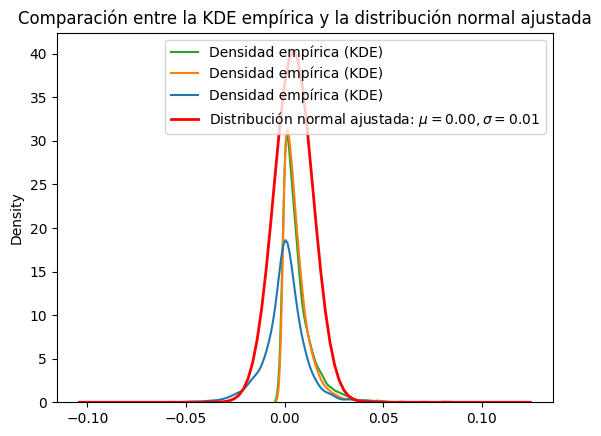

In [ ]:
comparar_distribucion_normal(ftrain)

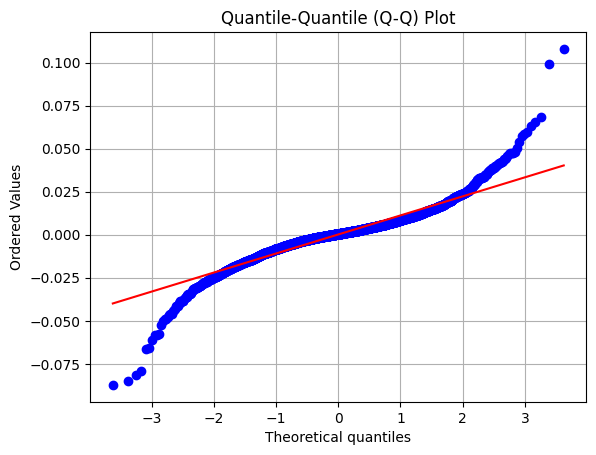

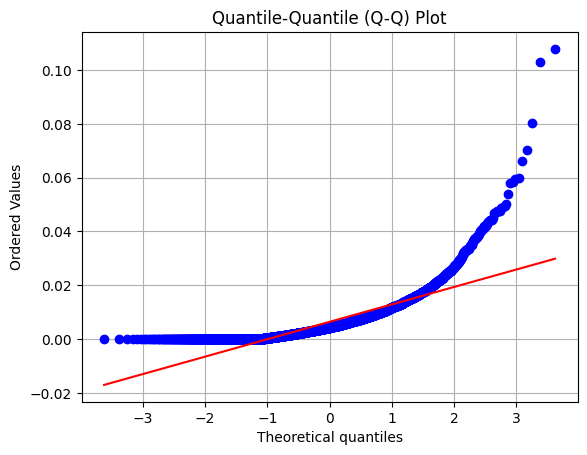

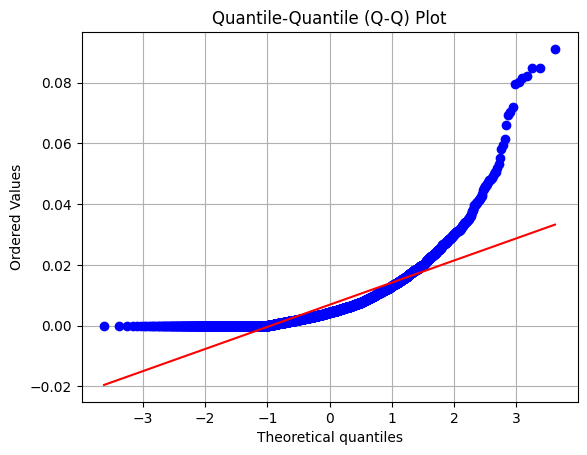

In [ ]:
qq_plot(feature1)
qq_plot(feature2)
qq_plot(feature3)

## Modelo

Ahora, podemos utilizar AIC, BIC y LL para comprobar cuál es el modelo con el mejor rendimiento de acuerdo a la cantidad de estados. Para la creación de un HMM usando la librería hmmlearn contamos con la ventaja que el método GaussianHMM ya realiza una normalización de los datos mediante Gaussian Mixing, así que basta con elegir cuantos estados deseamos y pasar los datos.


In [ ]:
aic = []
bic = []
lls = []
ns = [3 , 5 , 6 , 7, 8, 9, 10, 11]
X = ftrain
for n in ns:
    best_ll = None
    best_model = None
    for i in range(10):
        h = GaussianHMM(n_components=n)
        h.fit(X)
        score = h.score(X)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = h
    aic.append(best_model.aic(X))
    bic.append(best_model.bic(X))
    lls.append(best_model.score(X))

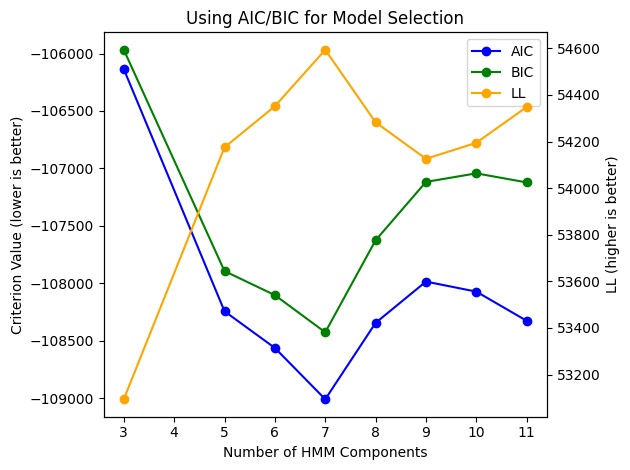

In [ ]:
fig, ax = plt.subplots()
ln1 = ax.plot(ns, aic, label="AIC", color="blue", marker="o")
ln2 = ax.plot(ns, bic, label="BIC", color="green", marker="o")
ax2 = ax.twinx()
ln3 = ax2.plot(ns, lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

In [ ]:
print(best_model.bic(X))
print(best_model.aic(X))
print(best_model.score(X))

-107121.43989094178
-108325.22939827731
54348.614699138656


In [ ]:
model = best_model

Luego de elegir el modelo que tuvo el mayor desempeño vamos a realizar predicciones, para esto vamos a acotar las posibilidades. Primero vamos a seleccionar una cantidad fija de valores para cada caracteristica, y segundo vamos a acotar los valores de las caracteristicas.

In [ ]:
test_augmented = features(test_d)

fraco = test_augmented['OpenClose'] #Feature 1
frach = test_augmented['HighOpen'] #Feature 2
fracl = test_augmented['LowOpen'] #Feature 3

sample_space_fraco = np.linspace(fraco.min(), fraco.max(), 50) # Creamos el intervalo y tomamos 50
sample_space_fracl = np.linspace(fracl.min(), frach.max(), 10) # Creamos el intervalo y tomamos 10
sample_space_frach = np.linspace(frach.min(), frach.max(), 10) # Creamos el intervalo y tomamos 10

possible_outcomes = np.array(list(itertools.product(sample_space_fraco, sample_space_frach, sample_space_fracl))) # Producto cartesiano

In [ ]:
print(possible_outcomes.shape)

(5000, 3)


In [ ]:
num_latent_days = 50
num_days_to_predict = 300

Vamos entonces a predecir con una secuencia de tamaño 51, siendo el valor 51 nuestra posiblidad y usando el modelo creado para evaluar qué tan probable es la secuencia. Haciendo esto con todas las posibilidades y seleccionando la mas probable podemos tener una buena predicción.

In [ ]:
predicted_close_prices = []
for i in tqdm(range(num_days_to_predict)):

    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)

    previous_data = stack_features(features(test_d.iloc[previous_data_start_index:previous_data_end_index])) # Datos de los días anteriores

    outcome_scores = []
    for outcome in possible_outcomes:

        total_data = np.row_stack((previous_data, outcome)) # Agregamos los resultados para ver cual secuencia tiene mejor desempeño
        outcome_scores.append(model.score(total_data))

    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)] # Tomamos la secuencia que tuvo el mejor desempeño
    predicted_close_prices.append(test_d.iloc[i]['Open'] * (1 + most_probable_outcome[0])) # Teniendo el cuenta el valor de apertura predecimos el valor de cierre

100%|██████████| 300/300 [10:35<00:00,  2.12s/it]


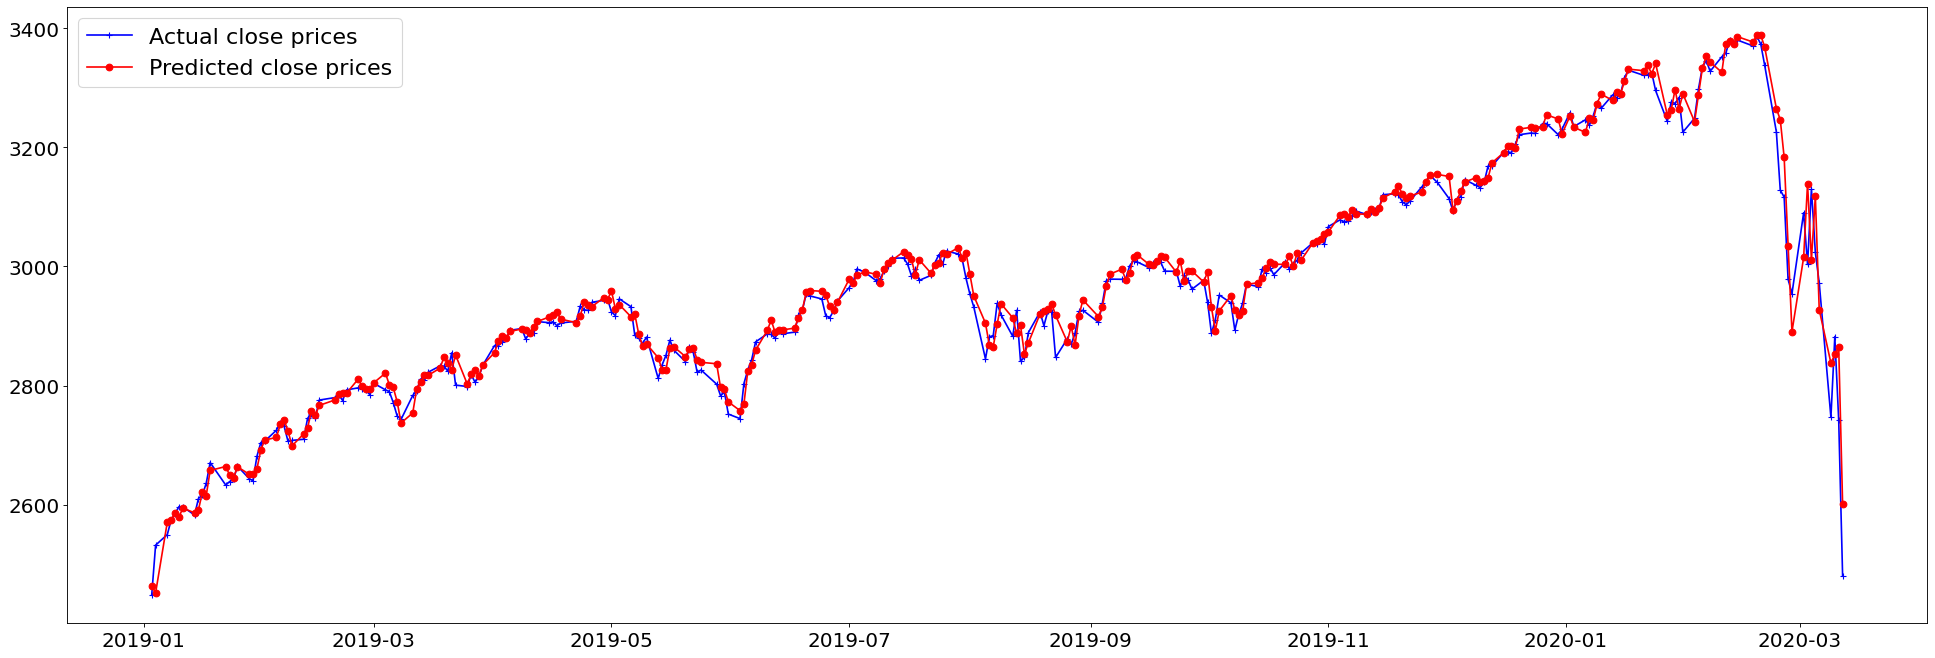

In [ ]:
plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_d.index[0:num_days_to_predict], dtype='datetime64[ms]')
plt.plot(x_axis, test_d.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predicted_close_prices, 'ro-', label="Predicted close prices")
plt.legend(prop={'size': 20})
plt.show()

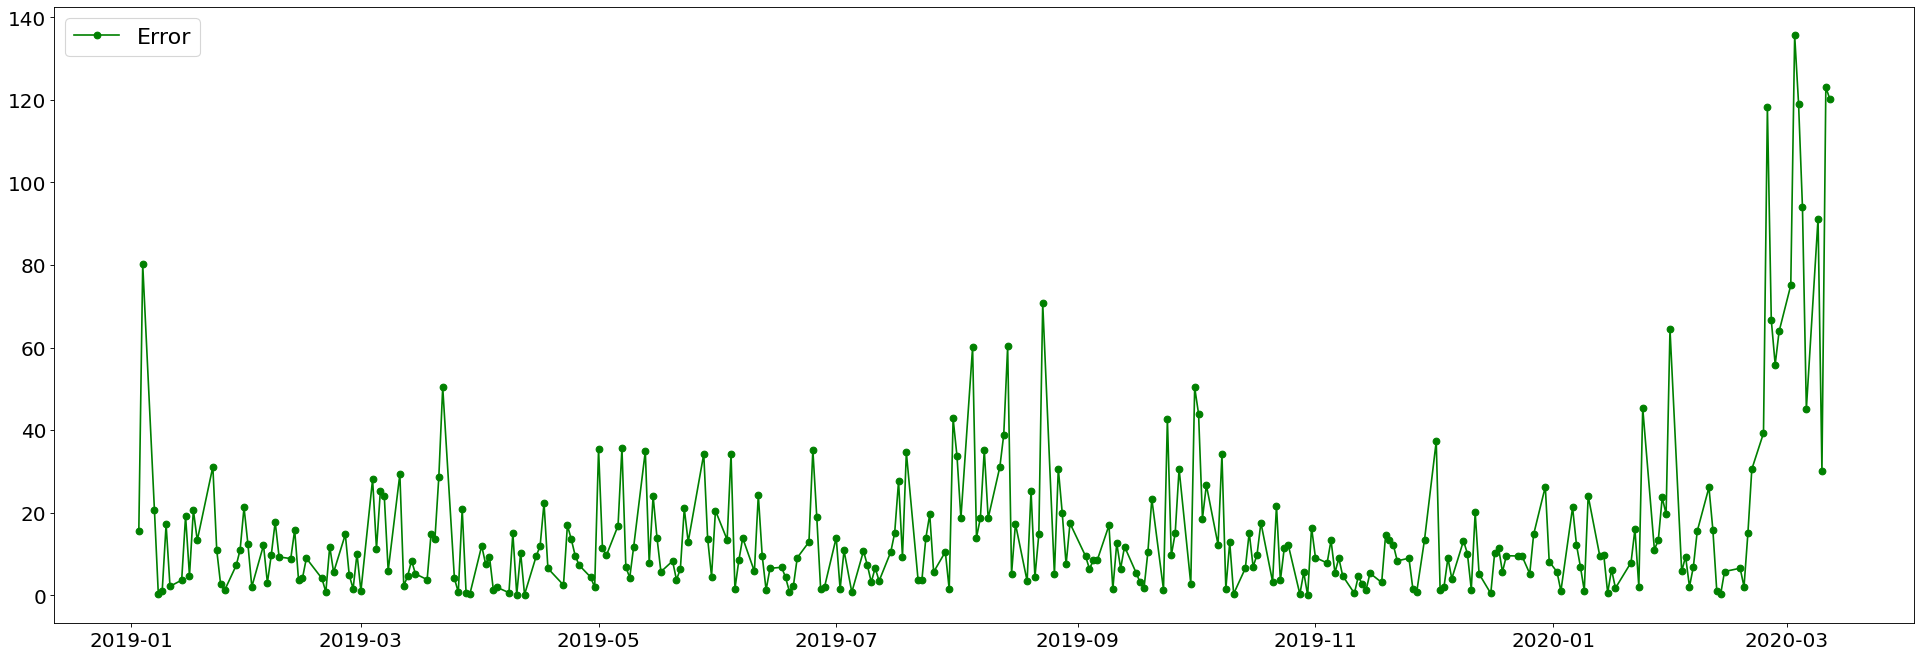

In [ ]:
ae = abs(test_d.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)

plt.figure(figsize=(30,10), dpi=80)

plt.plot(x_axis, ae, 'go-', label="Error")
plt.legend(prop={'size': 20})
plt.show()

Cómo se puede notar las predicciones son bastante buenas, aún cuando la cadena de Markov no es de orden alto somos capaces de predecir con un error máximo de menos de 140, y teniendo en cuenta que los valores de cierre rondan los miles no estamos muy alejados del precio.